# Image Processing Assignment 4: Edge Detection and Hough Transform

Before we start, please put your names and IDs in following format

: Firstname LASTNAME, #00000000   //   (e.g.) Dana LEVI, #12345678

**Your Answer:**   
Marah Habashi , #211668751

Celine Karam , #314658428

In this exercise, you will implement the **Edge Detection** and the  **Hough Transform** algorithms.

Methods: as explained in class.

Notes:
*   Write your code in the dedicated areas (TODO blocks). You can add helper functions.
*   Submission email should include a link to the Colab submission notebook located on your Google Drive with Commenter access right to nev1958a@gmail.com
*   The solution notebook should be able to be run (‘Run all’) with no errors.
In case of errors, the submission will be disqualified.
*   The grade will depend on correct performance on several grayscale images and on clean programming and documentation.
*   Do not forget to add the Names and Student I.D. at the top of the notebook.
*   All images are given as 2-dimensional matrices of type `float`, with values in the range [0..1].
*   Pay Attention! In the following functions, the returned images must be the same size as the original Images!

Please implement the following functions:
1. Write the `edge_detect` function which finds the edges using the Canny Edge Detector. Remember to first smooth the image. The input of the function is a grayscale image The output should be a binary image with only the edges(matrix  with zeros and ones), and the `tg_theta` (matrix of the tangent of the gradient angle). You should use the hysteresis threshold (`t_high`, `t_low` thresholds).
2. Write the `find_circles` function which finds circles in the given grayscale image using Hough transform. The function should print the list of circles in this image and return it as a matrix where each row represent a circle and contains 3 values: `origin_x`, `origin_y` and `radius`. In addition, the function should return an image (`img_c`) which contains the original image and the marked circles (draw the circles which you have found on the original image). **This function should use the previous `edge_detect` function on the given image before performing the Hough transform.**
 - **Remember to use the `tg_theta` to improve the complexity of the algorithm!**

**Note** In these images, **1** represents the object, and **0** (black) represents the background.

**Note** You should make sure the function work on `balls4.tiff`.

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You will need to rerun this setup code each time you start the notebook.

In [ ]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve

In [ ]:
GITHUB_PATH = 'https://raw.githubusercontent.com/dnevo/ImageProcessing/main/images/'

In [ ]:
def read_file(file_name:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image 
    in a numpy array.

    Args:
        file_name: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, file_name)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [ ]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

## `edge_detect`

In [ ]:
def edge_detect(img: np.array, t_low: np.float32, t_high: np.float32) \
    -> (np.array, np.array):
    '''
    This function receives a grayscale image and locate its edges using the 
    Canny Edge Detector algorithm.

    Args:
        img:    image array in float format (range: 0..1) - the source grayscale 
                image.
        t_low:  float format (range: 0..1), the Low threshold value.
        t_high: float format (range: 0..1), the High threshold value.

    Returns:
        img_e:    array in int format (values: 0, 1) - binary image with edges
                    pixels set to 1.
        tg_theta: array in float format (range: 0..1) - the matrix of the 
                    tangents of the gradients angles.
    '''
    ######################################################################
    # TODO: Implement The edge_detect algorithm.
    ######################################################################
    # Step 1: Smooth the image with a filter:
    img_s = convolve(img, np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16, 'same')

    # Step 2: Create S (gradients matrix) and tg_theta (grad angles)
    Sx = convolve(img_s, np.array([[1, -1]]), 'same')
    Sy = convolve(img_s, np.array([[1], [-1]]), 'same')
    S = np.sqrt(Sx*Sx + Sy*Sy)
    Sx[Sx==0] = 0.0001 
    tg_theta = Sy / Sx    


    # Step 3: Thresholding
    img_e = np.zeros_like(img)

    # Step 3.1: Pass 1: from top-left to bottom-right
    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            if S[r, c] < t_low:
                img_e[r, c] = 0
            elif S[r, c] > t_high:
                img_e[r, c] = 1
            else:
                img_e[r, c] = np.any(img_e[r-1:r+2, c-1:c+2])

    # Step 3.2: Pass 2: from bottom-right to top-left
    for r in range(img.shape[0]-2, 0, -1):
        for c in range(img.shape[1]-2, 0, -1):
            if S[r, c] < t_low:
                img_e[r, c] = 0
            elif S[r, c] > t_high:
                img_e[r, c] = 1
            else:
                img_e[r, c] = np.any(img_e[r-1:r+2, c-1:c+2])

    # Step 3.3: Compute the grad main directions (1..4)
    grad_dir = np.zeros_like(img)
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            if -0.4142 <= tg_theta[r, c] <= 0.4142:
                grad_dir[r, c] = 1
            elif 0.4142 < tg_theta[r, c] <= 2.4142:
                grad_dir[r, c] = 2
            elif tg_theta[r, c] > 2.4142:
                grad_dir[r, c] = 3
            elif -2.4142 <= tg_theta[r, c] < -0.4142:
                grad_dir[r, c] = 4

    # Step 3.4: Non Max Suppress
    for r in range(1, img.shape[0]-1):
      for c in range(1, img.shape[1]-1):
          if img_e[r, c] == 0:
              continue
          if grad_dir[r, c] == 1:
              if S[r, c] < max(S[r, c-1], S[r, c+1]):
                  img_e[r, c] = 0
          elif grad_dir[r, c] == 2:
              if S[r, c] < max(S[r-1, c-1], S[r+1, c+1]):
                  img_e[r, c] = 0
          elif grad_dir[r, c] == 3:
              if S[r, c] < max(S[r-1, c], S[r+1, c]):
                  img_e[r, c] = 0
          else:
              if S[r, c] < max(S[r-1, c+1], S[r+1, c-1]):
                  img_e[r, c] = 0 

    
    ######################################################################
    #                            END OF YOUR CODE                        #
    ######################################################################
    return img_e, tg_theta

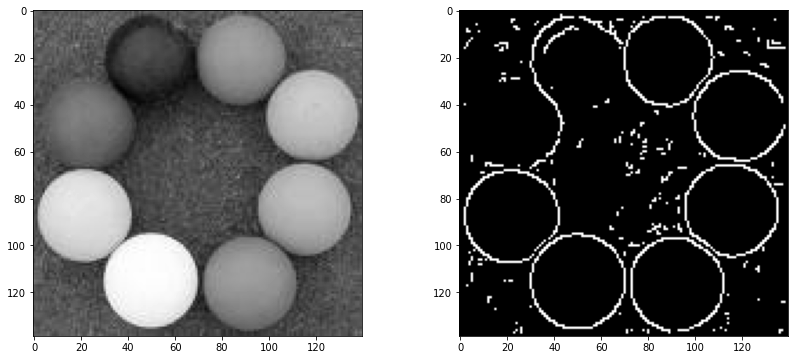

In [ ]:

img1 = read_file(file_name='balls1.tiff') / 255
img1_e, tg_theta1 = edge_detect(img=img1, t_low=9/255, t_high=10/255)
plot_images(img1, img1_e)

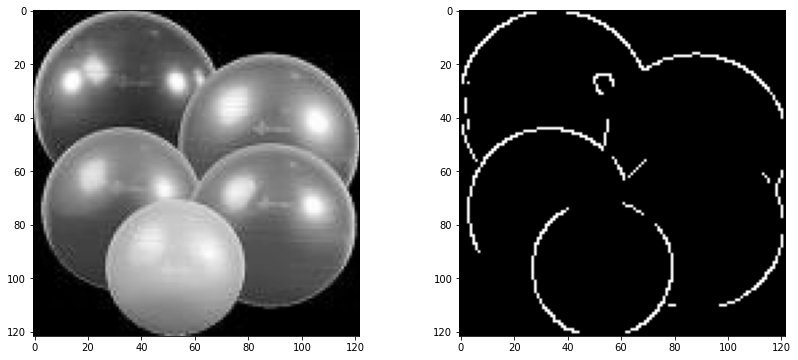

In [ ]:
img4 = read_file(file_name='balls4.tiff') / 255
img4_e, tg_theta = edge_detect(img=img4, t_low=34/255, t_high=39/255)
plot_images(img4, img4_e)

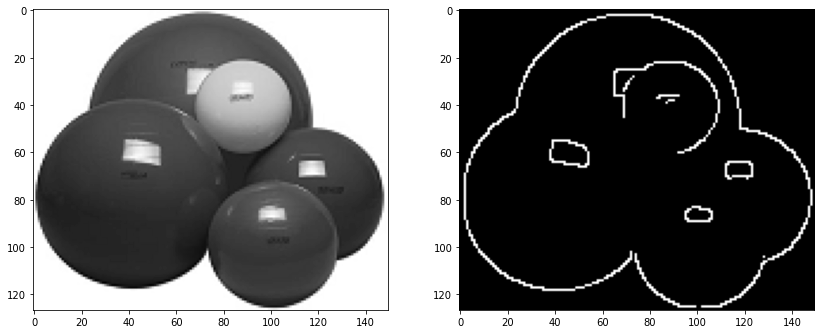

In [ ]:
img5 = read_file(file_name='balls5.tiff') / 255
img5_e, tg_theta5 = edge_detect(img=img5, t_low=23/255, t_high=30/255)
plot_images(img5, img5_e)

## `find_circles`

In [ ]:
def find_circles(img: np.array, t_low: np.float32, t_high: np.float32) -> (np.array, list):
    '''
    This function receives a grayscale image and finds circles in it using Hough
    transform. 
    The function is using the edge_detect function on the given image before 
    performing the Hough transform.
    It also use the tg_theta array to improve the complexity of the algorithm.
    The function also returns a list of the found circles.

    Args:
        img:    image array in float format (range: 0..1) - the source grayscale 
                image.
        t_low:  float format (range: 0..1), the Low threshold value.
        t_high: float format (range: 0..1), the High threshold value.

    Returns:
        img_c:   RGB image array in float format (range: 0..1) which contains 
                    the original image and the marked circles which were found.
        circles: a list - each element represent a circle and contains a list of
                    3 values: origin_x, origin_y, radius
    '''
    ######################################################################
    # TODO: Implement The find_circles algorithm.
    ######################################################################
    # Step 1:apply Edge Detection
    edges , tg_theta =  edge_detect(img, t_low, t_high)

    # Step 2: create the count matrix (centers(cx, cy) per radius (r) counters)
    img_nrows, img_ncols =img.shape
    min_r =14 
    max_r = round(min(img_ncols, img_nrows) / 2)
    count_matrix = np.zeros((img_ncols, img_nrows, max_r), dtype=np.int32)
    for x in range(img_ncols):
        for y in range(img_nrows):
            if edges[y,x] == 0:
                continue
            if  abs(tg_theta[y,x]) <= 1:
                for cx in range(max(x - max_r, 0), min(x + max_r, img_ncols)):
                    cy = round(tg_theta[y, x] * (cx - x) + y)
                    r = round(np.sqrt((cx - x)**2 +(cy - y)**2))
                    if 0 < cy < img_nrows and 0 < r < max_r:
                        count_matrix[cx, cy, r] +=1
            else:
                for cy in range (max(y - max_r, 0), min(y + max_r, img_nrows)):
                    cx = round((cy-y)/tg_theta[y, x] + x)
                    r = round(np.sqrt((cx - x)**2 +(cy - y)**2))
                    if 0 < cx < img_ncols and 0 < r < max_r:
                        count_matrix[cx, cy, r] +=1
  
    # Step 3: locate the real circles
    count_matrix = convolve(count_matrix, np.ones(shape=(5, 5, 5))/(5**3),  'same' )

    img_c = np.zeros((img_nrows, img_ncols))
    circles = []
    threshold = max_r/25
    D = 15
    for cx in range(img_ncols):
        for cy in range(img_nrows):
            for r in range(min_r,max_r):
                if count_matrix[cx, cy, r] <= threshold:
                    continue
                neighbours = count_matrix[max(cx-D, 1):min(cx+D, img_ncols), max(cy-D, 1):min(cy+D, img_nrows), max(r-D,min_r):min(r+D, max_r)]
                if count_matrix[cx, cy, r] < np.max(neighbours):
                    continue
                circles.append([cx, cy, r])
                theta = 0
                while theta <= 2*np.pi:
                    pt = np.round(np.array([cx,cy]) + np.array([r*np.cos(theta),r*np.sin(theta)]))
                    irow = int(pt[1])
                    icol = int(pt[0])
                    if 0 < irow < img_nrows and 0 < icol < img_ncols:
                        img_c[irow, icol] = 1
                    theta = theta + 1/r
    ######################################################################
    #                            END OF YOUR CODE                        #
    ######################################################################
    return img_c, circles

[[42, 78, 40], [70, 49, 47], [89, 40, 20], [101, 99, 27], [120, 79, 28]]


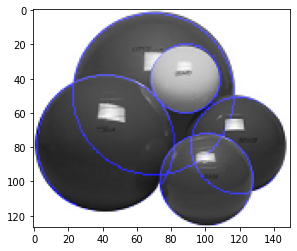

In [ ]:
img = read_file(file_name='balls5.tiff') / 255
img_c, circles = find_circles(img=img, t_low=1/255, t_high=2/255)

img_rgb = np.dstack((img, img, img))
img_rgb[:,:,2] += img_c
img_rgb = img_rgb.clip(0,1)
plt.imshow(img_rgb);
print(circles)

[[33, 74, 30], [37, 37, 36], [53, 95, 26], [88, 81, 30], [89, 49, 32]]


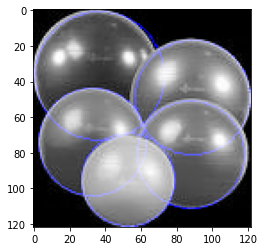

In [ ]:
img = read_file(file_name='balls4.tiff') / 255
img_c, circles = find_circles(img=img, t_low=1/255, t_high=2/255)

img_rgb = np.dstack((img, img, img))
img_rgb[:,:,2] += img_c
img_rgb = img_rgb.clip(0,1)
plt.imshow(img_rgb);
print(circles)